## Imports

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from os import listdir
from os.path import isfile, join

## Some initial config

In [81]:
INPUT_DIMS = [32,32]
BIN_DTYPE = 'int16'
PATH = "../Images/bin/"
SAMPLE = None
SPLIT = 0.3

## Generate label DataFrame

In [82]:
liver_images = np.array([f for f in listdir(PATH) if isfile(join(PATH, f))])
#print(f"Number of liver image files: {len(liver_images)}")
cancer_types = np.array([f.split('_')[0] for f in liver_images])
patient_numbers = np.array([int(f.split('_')[1]) for f in liver_images])
slice_numbers = np.array([int(f.split('_')[2].split('.')[0]) for f in liver_images])

ldata = {'filename' : liver_images, 
         'cancer_type' : cancer_types, 
         'patient_id' : patient_numbers, 
         'slice_number' : slice_numbers}

image_labels = pd.DataFrame(data=ldata).sort_values(['cancer_type','patient_id','slice_number'],
                                                   ignore_index=True)
if SAMPLE:
    image_labels = image_labels.sample(SAMPLE)
image_labels.head()

,filename,cancer_type,patient_id,slice_number
0,HCC_1_1.bin,HCC,1,1
1,HCC_1_2.bin,HCC,1,2
2,HCC_1_3.bin,HCC,1,3
3,HCC_1_4.bin,HCC,1,4
4,HCC_1_5.bin,HCC,1,5


### Display some sample images

In [83]:
def get_image(fpath,d_type=BIN_DTYPE,dims=INPUT_DIMS):
    '''
    Returns a numpy array given a .bin file path and
    image dimensionality. Assumes input bin files are square
    
    Parameters
        fpath: file path to .bin file
        d_type: data type of .bin file
        dims: image dimensionality
    Returns
        image: numpy array from bin file data
    '''
    im_data = np.fromfile(fpath,d_type)
    n = int(np.sqrt(len(im_data)))
    image = np.reshape(np.fromfile(fpath,d_type),[n,n])
    scaled_image = cv2.resize(image,dims)
    return scaled_image

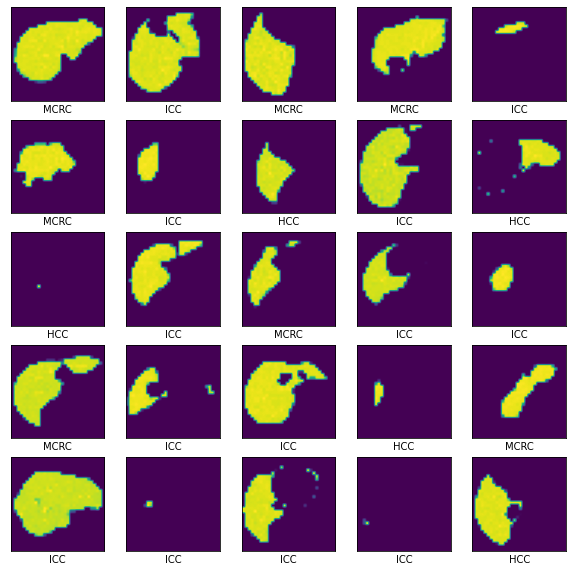

In [84]:
sample_labels = image_labels.sample(25)


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    img = get_image(PATH+sample_labels.filename.iloc[i])
    ctype = sample_labels.cancer_type.iloc[i]
    plt.imshow(img)
    plt.xlabel(ctype)
plt.show()

## Split Data into training and testing sets

In [85]:
#split df into cancer types
HCC_labels = image_labels.loc[image_labels.cancer_type == 'HCC']
ICC_labels = image_labels.loc[image_labels.cancer_type == 'ICC']
MCRC_labels = image_labels.loc[image_labels.cancer_type == 'MCRC']
print(f"{len(HCC_labels)} HCC images found")
print(f"{len(ICC_labels)} ICC images found")
print(f"{len(MCRC_labels)} MCRC images found")

5974 HCC images found
13140 ICC images found
9482 MCRC images found


In [86]:
def split_patients(pat_ids):
    train, test = train_test_split(pat_ids, test_size=SPLIT)
    return train, test

In [87]:
from sklearn.model_selection import train_test_split

hcc_train_ids, hcc_test_ids = split_patients(HCC_labels.patient_id.unique())
icc_train_ids, icc_test_ids = split_patients(ICC_labels.patient_id.unique())
mcrc_train_ids, mcrc_test_ids = split_patients(MCRC_labels.patient_id.unique())

HCC_train_labels = HCC_labels.loc[HCC_labels.patient_id.isin(hcc_train_ids)]
HCC_test_labels = HCC_labels.loc[HCC_labels.patient_id.isin(hcc_test_ids)]

ICC_train_labels = ICC_labels.loc[ICC_labels.patient_id.isin(icc_train_ids)]
ICC_test_labels = ICC_labels.loc[ICC_labels.patient_id.isin(icc_test_ids)]

MCRC_train_labels = MCRC_labels.loc[MCRC_labels.patient_id.isin(mcrc_train_ids)]
MCRC_test_labels = MCRC_labels.loc[MCRC_labels.patient_id.isin(mcrc_test_ids)]

In [88]:
train_rows=pd.concat([MCRC_train_labels,ICC_train_labels,HCC_train_labels],ignore_index=True).sample(frac=1)
test_rows=pd.concat([MCRC_test_labels,ICC_test_labels,HCC_test_labels],ignore_index=True).sample(frac=1)
print(f"Train test ratio: {len(train_rows)/(len(train_rows)+len(test_rows))}")

Train test ratio: 0.7127919988809623


In [89]:
# dict to map cancer types to numerical classes
c_class = {'HCC':0,
          'ICC':1,
          'MCRC':2}

In [90]:
#preallocate training data array
n_train = len(train_rows)
train_images = np.zeros([n_train]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_train):
    print(f"{i+1}/{n_train}", end='\r')
    train_images[i,:,:]=get_image(PATH+train_rows.filename.iloc[i])

train_labels = np.array([[c_class[c]] for c in train_rows.cancer_type.tolist()])

In [91]:
#preallocate testing data array
n_test = len(test_rows)
test_images = np.zeros([n_test]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_test):
    print(f"{i+1}/{n_test}", end='\r')
    test_images[i,:,:]=get_image(PATH+test_rows.filename.iloc[i])

test_labels = np.array([[c_class[c]] for c in test_rows.cancer_type.tolist()])

## Create Convolutional Base

In [99]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(INPUT_DIMS[0], INPUT_DIMS[0],1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [100]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-trai

In [101]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=50, batch_size=32,
                    validation_data=(train_images, train_labels),verbose=True)

Epoch 1/50
637/637 [==============================] - 13s 20ms/step - loss: 2.8147 - accuracy: 0.4755 - val_loss: 0.9994 - val_accuracy: 0.5090
Epoch 2/50
637/637 [==============================] - 12s 20ms/step - loss: 1.0029 - accuracy: 0.5043 - val_loss: 1.0091 - val_accuracy: 0.5038
Epoch 3/50
637/637 [==============================] - 13s 20ms/step - loss: 0.9878 - accuracy: 0.5131 - val_loss: 0.9507 - val_accuracy: 0.5348
Epoch 4/50
637/637 [==============================] - 13s 21ms/step - loss: 0.9709 - accuracy: 0.5228 - val_loss: 0.9501 - val_accuracy: 0.5406
Epoch 5/50
637/637 [==============================] - 15s 23ms/step - loss: 0.9562 - accuracy: 0.5351 - val_loss: 0.9318 - val_accuracy: 0.5463
Epoch 6/50
637/637 [==============================] - 15s 23ms/step - loss: 0.9332 - accuracy: 0.5450 - val_loss: 0.9252 - val_accuracy: 0.5508
Epoch 7/50
637/637 [==============================] - 14s 22ms/step - loss: 0.9210 - accuracy: 0.5524 - val_loss: 0.8844 - val_accuracy:

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)